In [1]:
import os
import shutil
import warnings

import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn import metrics, preprocessing
from MulticoreTSNE import MulticoreTSNE as TSNE

from train import create_net, create_supcon
from utils.eval import eval_net, eval_supcon
from utils.datasets import AortaDataset3D
from utils import transforms as MT
from utils.datasets import AortaDataset3DCenter

warnings.filterwarnings("ignore")
np.random.seed(63910)
torch.manual_seed(53152)
torch.cuda.manual_seed_all(7987)
torch.backends.cudnn.deterministic = True

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [3]:
#2d数据集
transform = T.Compose([
    T.Resize(81), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(81), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
    #MT.GaussianResidual(3, 1, False),
])
val = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/', transform=transform, loader=lambda path: Image.open(path))
val_loader = DataLoader(val, batch_size=100, shuffle=True, num_workers=8, pin_memory=True, drop_last=False)

In [15]:
#3d数据集
transform = T.Compose([
    MT.Resize3D(81),
    MT.CenterCrop3D(81),
    MT.ToTensor3D(),
    MT.GaussianResidual(3, 1, False, True),
])
val = val = AortaDataset3DCenter('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/center/val/', transform=transform, depth=7, step=1, residual=False)
val_loader = DataLoader(val, batch_size=100, shuffle=True, num_workers=8, pin_memory=True, drop_last=False)

[INFO]: Creating dataset with 13503 examples. Depth:7, Step:1, Residual:False


In [8]:
#2d网络
# net1 = create_net(device, 1, 3, 'details/checkpoints/CrossEntropy/11-06_12:19:06/Net_best.pth', entire=True)
# net2 = create_net(device, 1, 1, 'details/checkpoints/CrossEntropy/11-06_12:22:36/Net_epoch49.pth', entire=True)
net1 = create_net(device, 'resnet', 34, 1, 3, 'details/checkpoints/CrossEntropy/01-06_14:49:32/Net_best.pth', entire=True)
net2 = create_net(device, 'resnet', 34, 1, 2, 'details/checkpoints/CrossEntropy/01-06_12:43:25/Net_best.pth', entire=True)
net1.eval()
net2.eval()
print('')

[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	3 output channels (classes)
	3D model: False

[INFO]: Model loaded from details/checkpoints/CrossEntropy/01-06_14:49:32/Net_best.pth
[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	2 output channels (classes)
	3D model: False

[INFO]: Model loaded from details/checkpoints/CrossEntropy/01-06_12:43:25/Net_best.pth



In [22]:
#3d网络
net1 = create_net(device, 'resnet', 34, 2, 3, 'details/checkpoints/CrossEntropy/01-06_01:02:46/Net_best.pth', entire=True, flag_3d=True)
net2 = create_net(device, 'resnet', 34, 2, 1, 'details/checkpoints/CrossEntropy/01-06_01:37:23/Net_best.pth', entire=True, flag_3d=True)
net1.eval()
net2.eval()
print('')

[INFO]: **********************************************************************
Network: ResNet3D_34
	2 input channels
	3 output channels (classes)
	3D model: True

[INFO]: Model loaded from details/checkpoints/CrossEntropy/01-06_01:02:46/Net_best.pth
[INFO]: **********************************************************************
Network: ResNet3D_34
	2 input channels
	1 output channels (classes)
	3D model: True

[INFO]: Model loaded from details/checkpoints/CrossEntropy/01-06_01:37:23/Net_best.pth



In [9]:
num_val_batches = len(val_loader)  # the number of batch
n_val = 12434

true_list = []
pred_list = []

for imgs, true_categories in tqdm(val_loader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)
    true_list += true_categories.tolist()

    with torch.no_grad():
        categories_pred1 = net1(imgs)

    pred1 = torch.softmax(categories_pred1, dim=1)
    pred1 = pred1.argmax(dim=1)
    datas = imgs[pred1 == 2]
    
    if datas.size(0) > 0:
        with torch.no_grad():
            categories_pred2 = net2(datas)

        pred2 = torch.softmax(categories_pred2, dim=1)
        pred2 = pred2.argmax(dim=1)
#         pred2 = torch.sigmoid(categories_pred2).squeeze(-1)
#         pred2 = (pred2>0.5).long()

    #     print(pred1)
    #     print(pred2)
    #     print(true_categories.shape[0])
    #     print(datas.shape[0])

        pred1[pred1 == 2] = pred2+2

    pred_list.extend(pred1.tolist())

In [8]:
print(metrics.classification_report(true_list, pred_list, digits=4))#这是加了sobel，sobel不均值滤波的结果

              precision    recall  f1-score   support

           0     0.9091    0.8770    0.8928      6522
           1     0.7904    0.9089    0.8456      4370
           2     0.7174    0.5701    0.6353      1149
           3     0.6618    0.3435    0.4523       393

    accuracy                         0.8430     12434
   macro avg     0.7697    0.6749    0.7065     12434
weighted avg     0.8419    0.8430    0.8385     12434



In [7]:
print(metrics.classification_report(true_list, pred_list, digits=4))#这是加了sobel，sobel均值滤波的结果

              precision    recall  f1-score   support

           0     0.9017    0.8864    0.8940      6522
           1     0.8121    0.8979    0.8529      4370
           2     0.7050    0.5596    0.6240      1149
           3     0.5269    0.3740    0.4375       393

    accuracy                         0.8441     12434
   macro avg     0.7364    0.6795    0.7021     12434
weighted avg     0.8402    0.8441    0.8402     12434



In [7]:
print(metrics.classification_report(true_list, pred_list, digits=4))#这是加了sobel，sobel不均值滤波的结果，单通道

              precision    recall  f1-score   support

           0     0.9091    0.8770    0.8928      6522
           1     0.7904    0.9089    0.8456      4370
           2     0.7445    0.5579    0.6378      1149
           3     0.5859    0.3817    0.4622       393

    accuracy                         0.8431     12434
   macro avg     0.7575    0.6814    0.7096     12434
weighted avg     0.8420    0.8431    0.8390     12434



In [7]:
print(metrics.classification_report(true_list, pred_list, digits=4))#这是加了sobel，sobel均值滤波的结果，单通道

              precision    recall  f1-score   support

           0     0.9017    0.8864    0.8940      6522
           1     0.8121    0.8979    0.8529      4370
           2     0.6677    0.5788    0.6200      1149
           3     0.6615    0.3282    0.4388       393

    accuracy                         0.8444     12434
   macro avg     0.7608    0.6728    0.7014     12434
weighted avg     0.8410    0.8444    0.8398     12434



In [10]:
print(metrics.classification_report(true_list, pred_list, digits=4))#不加sobel

              precision    recall  f1-score   support

           0     0.9087    0.8855    0.8969      6522
           1     0.8090    0.8973    0.8508      4370
           2     0.7240    0.5457    0.6223      1149
           3     0.4508    0.4198    0.4348       393

    accuracy                         0.8435     12434
   macro avg     0.7231    0.6871    0.7012     12434
weighted avg     0.8421    0.8435    0.8408     12434



In [7]:
print(metrics.classification_report(true_list, pred_list, digits=4))#不加sobel，单通道

              precision    recall  f1-score   support

           0     0.9087    0.8855    0.8969      6522
           1     0.8090    0.8973    0.8508      4370
           2     0.6694    0.5692    0.6152      1149
           3     0.5529    0.3588    0.4352       393

    accuracy                         0.8437     12434
   macro avg     0.7350    0.6777    0.6995     12434
weighted avg     0.8403    0.8437    0.8401     12434



In [21]:
print(metrics.classification_report(true_list, pred_list, digits=4))#3d，这是加了sobel，sobel均值滤波的结果

              precision    recall  f1-score   support

           0     0.9387    0.9111    0.9247      7591
           1     0.8304    0.9387    0.8812      4370
           2     0.8261    0.5831    0.6837      1149
           3     0.3854    0.3766    0.3810       393

    accuracy                         0.8765     13503
   macro avg     0.7451    0.7024    0.7176     13503
weighted avg     0.8779    0.8765    0.8743     13503



In [25]:
print(metrics.classification_report(true_list, pred_list, digits=4))#3d，这是加了sobel，sobel均值滤波的结果,单通道

              precision    recall  f1-score   support

           0     0.9387    0.9111    0.9247      7591
           1     0.8304    0.9387    0.8812      4370
           2     0.8029    0.6171    0.6978      1149
           3     0.4455    0.3537    0.3943       393

    accuracy                         0.8788     13503
   macro avg     0.7544    0.7051    0.7245     13503
weighted avg     0.8777    0.8788    0.8759     13503



In [5]:
net = create_supcon(device, 34, 1, True, 'details/checkpoints/SupCon/11-12_13:40:42/Net_last.pth')

[INFO]: **********************************************************************
Network: SupConResNet+resnet34
	1 input channels
	3D model: False

[INFO]: Model loaded from details/checkpoints/SupCon/11-12_13:40:42/Net_last.pth


(0.5699663365037944,
 'details/checkpoints/CrossEntropy/11-12_13:40:42/TSNE.png')

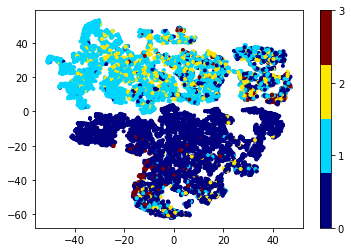

In [6]:
eval_supcon(net, val_loader, 12434, device, 4, True, 'details/checkpoints/CrossEntropy/11-12_13:40:42')

In [9]:
net = create_net(device, 34, 1, 4, 'details/checkpoints/CrossEntropy/11-10_17:56:10/Net_best.pth', entire=True)

[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	4 output channels (classes)
	3D model: False

[INFO]: Model loaded from details/checkpoints/CrossEntropy/11-10_17:56:10/Net_best.pth


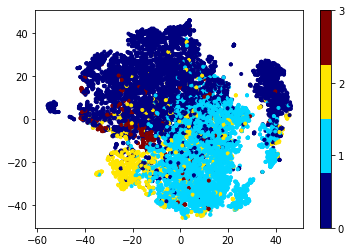

In [10]:
repr_list = []
label_list = []
def get_repr_vector(module, input, output):
    repr_list.append(input[0])
handle = net.fc.register_forward_hook(get_repr_vector)
    
for imgs, true_categories in tqdm(val_loader, total=len(val_loader), desc='Validation round', unit='batch', leave=False):
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)
    label_list.append(true_categories)
    with torch.no_grad():
        net(imgs)
        
handle.remove()
reprs = torch.cat(repr_list, dim=0).cpu().numpy()
labels = torch.cat(label_list, dim=0).cpu().numpy()
reprs_tsne = TSNE(n_jobs=8).fit_transform(reprs)
vis_x = reprs_tsne[:, 0]
vis_y = reprs_tsne[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 4), marker='.')
plt.colorbar(ticks=range(4))
plt.show()

In [4]:
net = create_net(device, 34, 1, 4, 'details/checkpoints/CrossEntropy/11-10_17:56:10/Net_best.pth', entire=True)
net.eval()
print(' ')

[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	4 output channels (classes)
	3D model: False

[INFO]: Model loaded from details/checkpoints/CrossEntropy/11-10_17:56:10/Net_best.pth
 


In [10]:
pau_list = []
for img in sorted(os.listdir('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1')):
    pau_list.append(os.path.join('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1', img))

In [11]:
tot_count = 0
err_count = 0
err_set = set()
for img in pau_list:
    tot_count += 1
    image = Image.open(img)
    tensor = transform(image).unsqueeze(0).to(device)
    res = net(tensor).squeeze()
    if res.argmax() != 1:
        err_count += 1
        print(res.argmax().item(), img)
        err_set.add(img.split('/')[-1].split('_')[0])
print(tot_count, err_count, err_count/tot_count)
print(sorted(list(err_set)))

0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/baochunsheng-J-20-82_j_0063.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/caiweiguang-J-Im35-152_j_0123.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chenbo-S-Im24-45-J-Im24-97_j_0032.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chenfujun-J-Im43-100_j_0073.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chenfujun-J-Im43-100_j_0095.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chenfujun-J-Im43-100_j_0099.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chengshizheng-J-Im30-145_j_0090.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chengyonghui-J-17-81_j_0065.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chenjiandong-S-19-28-J-19-91_j_0072.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chenping-J-Im23-88_j_0072.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/chensiqi-S-17

0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhangwei-S-20-26-J-20-61_j_0020.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhangwei-S-20-26-J-20-61_j_0052.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhangyunqin-S-Im14-25-J-Im14-64_j_0053.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhangyunqin-S-Im14-25-J-Im14-64_j_0060.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhaowenxian-J-Im43-111_j_0089.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhaowenxian-J-Im43-111_j_0107.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhaowenxian-J-Im43-111_j_0110.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhengguozheng-J-18-81_j_0064.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhengguozheng-J-18-81_j_0071.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/1/zhengguozheng-J-18-81_j_0072.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/

In [12]:
pau_list = []
for img in sorted(os.listdir('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1')):
    pau_list.append(os.path.join('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1', img))

In [13]:
tot_count = 0
err_count = 0
err_set = set()
for img in pau_list:
    tot_count += 1
    image = Image.open(img)
    tensor = transform(image).unsqueeze(0).to(device)
    res = net(tensor).squeeze()
    if res.argmax() != 1:
        err_count += 1
        print(res.argmax().item(), img)
        err_set.add(img.split('/')[-1].split('_')[0])
print(tot_count, err_count, err_count/tot_count)
print(sorted(list(err_set)))

2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenggang-J-Im18-81_j_0039.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenggang-J-Im18-81_j_0062.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenggang-J-Im18-81_j_0080.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjufa-J-16-66_j_0065.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjuli-J-Im18-49_j_0038.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjun-J-Im33-137_j_0068.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjun-J-Im33-137_j_0069.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjun-J-Im33-137_j_0070.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjun-J-Im33-137_j_0071.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjun-J-Im33-137_j_0078.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/chenjun-J-Im33-137_j_0101.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_

0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0029.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0030.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0031.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0032.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0033.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0034.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0035.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0036.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0037.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/hongzhimin-S-Im30-39-J-30-144_s_0038.png
3 /nfs3-p1/zsxm/data

2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/qiaowei-S-Im18-30-J-Im18-82_j_0043.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/qiaowei-S-Im18-30-J-Im18-82_j_0045.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shanghongjun-J-22-84_j_0044.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shaoxiulan-J-Im21-25_j_0020.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shaoxiulan-J-Im21-25_j_0021.png
3 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shengwenping-S-Im37-46-J-Im37-116_j_0037.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shengwenping-S-Im37-46-J-Im37-116_j_0042.png
3 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shengwenping-S-Im37-46-J-Im37-116_j_0064.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shengwenping-S-Im37-46-J-Im37-116_j_0076.png
3 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/shengwenping-S-Im37-46-J-Im37-116_j_0079.png
0 /nfs3-p1/zsxm/dataset/aorta_c

2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yaojianmin-S-Im20-29-J-Im20-86_j_0056.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yaojianmin-S-Im20-29-J-Im20-86_j_0057.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yaojianmin-S-Im20-29-J-Im20-86_j_0059.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yaojianmin-S-Im20-29-J-Im20-86_j_0067.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yaojianmin-S-Im20-29-J-Im20-86_j_0068.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yaojianmin-S-Im20-29-J-Im20-86_j_0075.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yesanghua-J-Im41-138_j_0049.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yewenyi-J-Im36-130_j_0094.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yewenyi-J-Im36-130_j_0101.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/yewenyi-J-Im36-130_j_0102.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1

0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/zhousuhua-J-Im25-96_j_0072.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/zhuhancheng-S-Im27-36-J-Im27-86_j_0074.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/zhuhancheng-S-Im27-36-J-Im27-86_j_0076.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/zhuhancheng-S-Im27-36-J-Im27-86_j_0080.png
0 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/zhuhancheng-S-Im27-36-J-Im27-86_j_0082.png
2 /nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/1/zhuhancheng-S-Im27-36-J-Im27-86_s_0029.png
4370 364 0.08329519450800915
['chenggang-J-Im18-81', 'chenjufa-J-16-66', 'chenjuli-J-Im18-49', 'chenjun-J-Im33-137', 'chenlili-S-Im18-24-J-Im18-74', 'chiyanfei-J-Im20-83', 'daizuokou-J-Im19-74', 'ganxiaobin-J-23-51', 'guojianfu-J-Im32-100', 'hongzhimin-S-Im30-39-J-30-144', 'huanglijun-J-24-98', 'huleijun-J-Im25-141', 'jilixian-J-Im34-108', 'jinchongfei-J-22-92', 'lijianming-J-Im32-124', 'lingenqiang-S-Im30-39

In [ ]:
['baochunsheng', 'caiweiguang', 'chenbo', 'chenfujun', 'chengshizheng', 'chengyonghui', 'chenjiandong', 'chenping', 'chensiqi', 'chugentang', 'fangchunfeng', 'fanghongwei', 'guanxujun', 'guoheying', 'guquankang', 'huangdebing', 'huanghai', 'huangsuyue', 'huangxihong', 'huangyong', 'huangyongliang', 'jiadeen', 'jihongke', 'laiguizhen', 'laixuexiang', 'lanshaomei', 'leixiaoying', 'lihuanhuan', 'liubihai', 'liyehua', 'louyidong', 'luojun', 'maliwei', 'pengzhengjiang', 'qumin', 'ruweiping', 'shaoyefeng', 'shenglina', 'shenqi', 'tangabiao', 'wangjiangwei', 'wangxiaofu', 'wangyonghui', 'wangyuefeng', 'wangzhengjin', 'wenyongguo', 'wuyueming', 'xiaminsong', 'xiashubiao', 'xuhangying', 'xuyaofeng', 'xuzhaofang', 'yangmin', 'yangxuehua', 'yangzhanxiang', 'yepeng', 'yexianchang', 'yexiyou', 'yujiada', 'zhangguangming', 'zhanghaitao', 'zhangwei', 'zhangyunqin', 'zhaowenxian', 'zhengguozheng', 'zhengjiyou', 'zhoufeng', 'zhouliang', 'zhuseng', 'zhuxutao', 'zhuyongfu', 'zhuyuejin', 'zongminghui']
['chenggang', 'chenjufa', 'chenjuli', 'chenjun', 'chenlili', 'chiyanfei', 'daizuokou', 'ganxiaobin', 'guojianfu', 'hongzhimin', 'huanglijun', 'huleijun', 'jilixian', 'jinchongfei', 'lijianming', 'lingenqiang', 'linjiaxiang', 'liuyunfei', 'loulinhua', 'lufeng', 'luzhiping', 'panzhangsong', 'qianfuying', 'qiaowei', 'shanghongjun', 'shaoxiulan', 'shengwenping', 'shenliqiang', 'shenxuefu', 'sishouzhong', 'wangqing', 'wutonggen', 'wuwanglong', 'wuxiangyang', 'xiafangzhou', 'xuhong', 'xushichao', 'yangbingshui', 'yanjuanfeng', 'yaocaiming', 'yaojianmin', 'yesanghua', 'yewenyi', 'yingguoliang', 'yingjianquan', 'yingmeiqi', 'yintianxing', 'yuanlinyue', 'yuguiying', 'yuhongliang', 'yujiazhen', 'zhangboqian', 'zhangfuyang', 'zhangjian', 'zhanglimin', 'zhongxuefang', 'zhoubozhong', 'zhoumingfang', 'zhousuhua', 'zhuhancheng']

In [13]:
import torch
from models.SupCon import *
from models.convnext import convnext_tiny

net1 = resnet(34, n_channels=1, n_classes=3, entire=True)
net2 = convnext_tiny(in_chans=1, num_classes=3)

print('ResNet:  ', sum([param.nelement() for param in net1.parameters()]))
print('ConvNeXt:', sum([param.nelement() for param in net2.parameters()]))

ResNet:   21279939
ConvNeXt: 27819363
